In [1]:
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn # Base module for implementing Neural Networks
import torch.nn.functional as F # This manually forwards the data from one layer to the next
from torch.optim import Adam # Model Optimizer

from torch.utils.data import DataLoader # This allowes us to load data in batches
from torchvision import datasets, transforms

torch.manual_seed(101);

In [2]:
# Set transform
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(
    root = "../datasets/",
    train = True,
    download = True,
    transform = transform
)

D:\Codehub\dl-medical\env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
test_data = datasets.MNIST(
    root = '../datasets/',
    train = False,
    download = True,
    transform = transform
)

In [5]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../datasets/
    Split: Test
    StandardTransform
Transform: ToTensor()


60000
torch.Size([1, 28, 28])


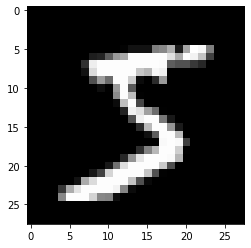

In [6]:
image, label = train_data[0]
print(len(train_data))
print(image.shape) # tensor format: Channel, width, height
plt.imshow(image.reshape(28,28), cmap='gray')

In [7]:
train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 500, shuffle = False)

print(f"train_loader: {len(train_loader)}")
print(f"test_loader: {len(test_loader)}")

train_loader: 600
test_loader: 20


In [8]:
from torchvision.utils import make_grid
np.set_printoptions(formatter = dict(int=lambda x: f"{x:5}")) # FORMATTING

In [9]:
for images,labels in train_loader:
    break
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


Labels:
 [    7     2     3     5     8     5     3     6     9     9     1     3]


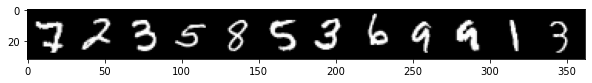

In [10]:
print(f'Labels:\n {labels[:12].numpy()}')

im = make_grid(images[:12], nrow=12).numpy()
plt.figure(figsize = (10,4))
# Transpose images from Channel, Width, Height (CWH) to WHC
# np.transpose(a,b)
# b => Tuple => (x,y,z) Order of transposing the index
plt.imshow(np.transpose(im, (1,2,0))); 

In [11]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_sz = 784, out_sz=10, layers = [120,84]):
        # in_sz = size of input layer
        # out_sz = size of output layer
        # layers = number of neurons in each layer (indexed based)
        
        super().__init__()
        
        # Here fc is a function initialized by nn.Linear(), it accepts input parameter X, hence fc(X)
        self.fc1 = nn.Linear(in_sz,layers[0]) # Fully connected Layer: input -> hidden_1
        self.fc2 = nn.Linear(layers[0],layers[1]) # Fully connected Layer: hidden_1 -> hidden_2
        self.fc3 = nn.Linear(layers[1], out_sz) # Fully connected Layer: hidden_2 -> output
        
    def forward(self,X):
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X),dim=1)
        
        return X

In [12]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
print(f"# of parameters: {sum([p.numel() for p in model.parameters()])}")

# of parameters: 105214


In [14]:
criterion = nn.CrossEntropyLoss() # Loss Function
optimizer = Adam(model.parameters(),lr=0.001) # Optimizer

In [15]:
images.view(-1,784).shape

torch.Size([100, 784])

In [16]:
import time

start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    test_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Forward pass
        y_pred = model(X_train.view(-1,784))
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1] # This essentially fetches the max value across columns (axis=1) of each row in a batch and return index, hence the [1]
        batch_corr = (predicted == y_train).sum() # This returns a scalar tensor
        trn_corr += batch_corr
        
        # Backward pass
        optimizer.zero_grad() # Resets gradients to 0 as it is accumulated from previous batch
        loss.backward() # Perform backpropogation
        optimizer.step() # Adjust the parameters of the model
        
        if b%200 == 0:
            accuracy = trn_corr.item()*100/(100*b)
            clear_output(wait=True)
            print(f'[Epoch {i}] Batch {b} | loss: {loss.item()} | accuracy: {round(accuracy,2)}%')
    
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Disable gradient computation during inference
    # With clause helps to disable it and renable it once done executing the block
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            y_val = model(X_test.view(-1,784))
            predicted = torch.max(y_val.data,1)[1]
            test_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(test_corr.item())

total_time = time.time() - start_time
print(f"Duration: {total_time/60} mins")

[Epoch 9] Batch 600 | loss: 0.01973872445523739 | accuracy: 99.26%
Duration: 0.8301749110221863 mins


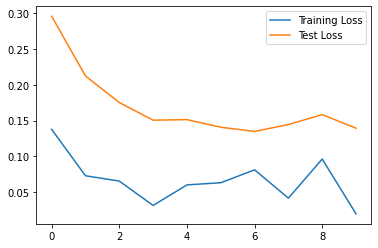

In [18]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()

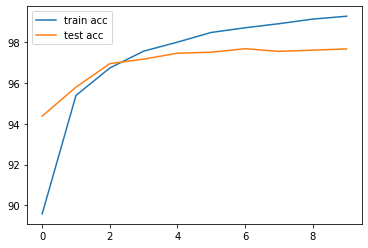

In [34]:
train_acc = [(t/60000)*100 for t in train_correct]
test_acc = [(t/10000)*100 for t in test_correct]

plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label = 'test acc')
plt.legend()

In [39]:
# Load Unseen data

test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)
print(f"Batch Size: {len(test_load_all)}")
print(f"Size of each batch: {test_load_all.batch_size}")

Batch Size: 1
Size of each batch: 10000


In [54]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(-1,784))
        predicted = torch.max(y_val,1)[1]
        correct+=(predicted == y_test).sum()
print(f'Accuracy on Unseen Data: {correct.item()/10000*100}%')
print(f"confusion matrix:\n {confusion_matrix(predicted.view(-1),y_test.view(-1))}")

Accuracy on Unseen Data: 97.66%
confusion matrix:
 [[  970     0     5     0     1     2     5     2     3     3]
 [    0  1124     4     0     0     0     3     7     0     2]
 [    1     3   999     2     1     0     2     9     3     0]
 [    2     2     8   985     0    11     1     2     4     3]
 [    1     0     3     0   959     3     3     2     2     6]
 [    0     0     0     8     0   866     5     1     3     2]
 [    1     1     1     0     6     2   938     0     1     0]
 [    0     0     4     5     1     0     0   984     3     0]
 [    3     5     8     3     2     7     1     3   951     3]
 [    2     0     0     7    12     1     0    18     4   990]]


97.66